<a href="https://colab.research.google.com/github/OrLevari/OrLevariPortfolio/blob/main/Erica's_Laundry_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 'Drop Off' Data Processing

In [3]:
#Load Drop Off Data
d2022 = pd.read_excel('/content/drop 22.xlsx', header=1)
d2023 = pd.read_excel('/content/drop 23.xlsx', header=1)
d2024 = pd.read_excel('/content/drop 24.xlsx', header=1)

In [4]:
#Cleaning and fixing duplicates in data
for year in (2022, 2023, 2024):

    #Acess multiple data frames dynamically
    df = globals()[f'd{year}']

    #Fix name entry issues with Z's
    df['First Name'] = df['First Name'].str.replace('^(Zz{1,3})', '', regex=True)
    df['Last Name'] = df['Last Name'].str.replace('^(Zz{1,3})', '', regex=True)

    #Create "Full Name" composite key column for better accessing and merging
        #note: for portfolio presentation index will be used as customer identifier
    df.insert(0, 'Full Name', df['First Name']+' '+df['Last Name'])
    df.drop(columns=['First Name', 'Last Name', 'Total'], inplace=True)

    #Add year to month columns for each years' data (necessary for when merging)
    new_column_names = {}
    for col in df.columns[3:15]:
      new_column_names[col] = col + " " + str(year)
    df.rename(columns=new_column_names, inplace=True)

    #Group by customers to fix purchases in multiple customer entries
    df = df.groupby('Full Name', as_index=False)[df.columns[3:15]].sum()

    #Re-assign cleaned data frame
    globals()[f'd{year}'] = df

In [5]:
#Merging to create single data source for 2022-2024
data = pd.merge(d2022, pd.merge(d2023, d2024, on='Full Name', how='outer'), on='Full Name', how='outer')
data.fillna(0, inplace=True)

#Adjust end columns based on current month
next_month = 4
index = 12-next_month
data.drop(data.columns[-index-1:], axis=1, inplace=True)

#Data frame without confidential information to present in portfolio
#Set index as customer identifier
data_for_project = data.drop(columns='Full Name')
data_for_project.insert(0, 'Customer', data.index)
data_for_project

,Customer,Jan 2022,Feb 2022,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,...,Jun 2023,Jul 2023,Aug 2023,Sep 2023,Oct 2023,Nov 2023,Dec 2023,Jan 2024,Feb 2024,Mar 2024
0,0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
1,1,0.00,0.0,0.0,0.0,31.50,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
2,2,0.00,0.0,0.0,0.0,0.00,66.07,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
3,3,40.75,0.0,0.0,0.0,0.00,0.00,0.00,0.00,22.0,...,0.0,25.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
4,4,80.63,0.0,0.0,0.0,67.73,59.93,120.52,39.08,0.0,...,0.0,119.85,0.0,79.05,0.0,0.0,95.8,0.00,71.66,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,858,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,71.91
859,859,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,159.75,0.00,0.00
860,860,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,17.00,0.00,0.00
861,861,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,105.83,228.31,85.17


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [6]:
#863 customers
data.shape

(863, 28)

In [7]:
#Filter out clients with less than 3 months of purchases
months_with_purchases = (data.iloc[:, 1:] > 0).sum(axis=1)
data = data[(months_with_purchases>3)]
data.set_index('Full Name', inplace=True)

In [8]:
#266 customers
data.shape

(266, 27)

In [9]:
#Filter out clients whose last purchase was before 6/2022
  #Necessary for lag variable calculation, also such customer are not relevant anymore
mask = pd.to_datetime((data != 0).apply(lambda x: x[::-1].idxmax(), axis=1)) > '2022-06-01'
data = data[mask]

<ipython-input-9-d38966e59e81>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime((data != 0).apply(lambda x: x[::-1].idxmax(), axis=1)) > '2022-06-01'


In [10]:
#258 customers
data.shape

(258, 27)

# Variable Creation

In [11]:
#Variable Creation for customer retention predictive model
df = pd.DataFrame(index=data.index)

#First month customer made purchase
df['First Purchase']=(data != 0).idxmax(axis=1)

#Last/most recent customer purchase month
df['Last Purchase']=(data != 0).apply(lambda x: x[::-1].idxmax(), axis=1)

#Mean monthly revenue per customer (across active months only)
df['Average Monthly Revenue'] = round(data.sum(axis=1)/(data > 0).sum(axis=1), 2)

#Count of active months with purhchases
df['Months with Purchases'] = (data > 0).sum(axis=1)

#Function to count purhcase gaps
def count_consecutive_zeros(row):
    consecutive_zeros = 0
    count = 0
    for value in row:
        if value == 0.0:
            consecutive_zeros += 1
        else:
            if consecutive_zeros >= 1:
                count += 1
            consecutive_zeros = 0
    return count

#Count of purchase gaps between customer sales
df['Gap Frequency'] = data.apply(count_consecutive_zeros, axis=1)

for index, row in df.iterrows():
    if pd.to_datetime(row['First Purchase']) > pd.to_datetime('2022-01-01'):
        df.at[index, 'Gap Frequency'] -= 1

#Lag variable calculation
#Percentage change comparing to previous months sales (for 6 months starting from last/most recent purchase)
lag_data = pd.DataFrame(index=data.index)
lag_data['Last Purchase'] = pd.to_datetime(df['Last Purchase'])
data.columns = pd.to_datetime(data.columns)

#Created 7 month data frame for easier lag calculation
for month in range(0, 7):
    col_name = f'Month_{month+1}'
    lagged_values = []
    for idx, row in lag_data.iterrows():
        lagged_date = row['Last Purchase'] - pd.DateOffset(months=month)
        lagged_date_str = lagged_date.strftime('%Y-%m-%d')
        lagged_values.append(data.loc[idx][lagged_date_str])
    lag_data[col_name] = lagged_values

for lag in range(1, 7):
  col_name = f'Lag_{lag}'
  lag_value = (lag_data.iloc[:, lag]-lag_data.iloc[:, lag+1])/np.maximum(lag_data.iloc[:, lag+1], 1)
  df[col_name] = lag_value

#Explored seasonal join factor but ultimately was insiginficant
#df['Winter Join'] = ((((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) == 12) | (((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) <= 2)).astype(int)
#df['Spring Join'] = ((((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) >= 3) & (((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) <= 5)).astype(int)
#df['Summer Join'] = ((((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) >= 6) & (((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) <= 8)).astype(int)
#df['Fall Join'] = ((((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) >= 9) & (((pd.to_datetime(df['First Purchase']).dt.month).astype(int)) <= 11)).astype(int)

#Customer Retention classification = clients who have made purchase in last 3 months (in new year 2024)
df['Retain'] = (pd.to_datetime(df['Last Purchase']) > pd.to_datetime('Dec 2023')).astype(int)
df = df.reset_index(drop=False)

#Data frame without confidential information to present in portfolio
#Set index as customer identifier
df_for_project = df.drop(columns='Full Name')
df_for_project.insert(0, 'Customer', df.index)
df_for_project

<ipython-input-11-c9e6b35ee00b>:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lag_data['Last Purchase'] = pd.to_datetime(df['Last Purchase'])
<ipython-input-11-c9e6b35ee00b>:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.columns = pd.to_datetime(data.columns)
<ipython-input-11-c9e6b35ee00b>:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Retain'] = (pd.to_datetime(df['Last Purchase']) > pd.to_datetime('Dec 2023')).astype(int)


,Customer,First Purchase,Last Purchase,Average Monthly Revenue,Months with Purchases,Gap Frequency,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Retain
0,0,Nov 2022,Mar 2023,86.18,4,1,0.021867,0.003207,77.950000,-1.000000,108.680000,0.000000,0
1,1,Jan 2022,Feb 2024,82.04,12,8,71.660000,-1.000000,95.800000,0.000000,-1.000000,79.050000,1
2,2,Jan 2022,Jul 2022,84.47,7,0,-0.693796,0.102451,0.157587,0.621816,-0.315498,-0.152019,0
3,3,Feb 2022,Mar 2023,43.57,7,3,-0.414229,62.550000,-1.000000,28.050000,0.000000,0.000000,0
4,4,Nov 2022,Mar 2024,51.44,16,1,0.986842,0.020000,-0.040646,-0.518127,0.926412,0.140909,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,253,Mar 2023,Feb 2024,38.82,5,4,25.000000,0.000000,-1.000000,25.000000,0.000000,0.000000,1
254,254,Jul 2023,Mar 2024,41.72,7,2,0.385787,33.490000,-1.000000,-0.592701,61.380000,-1.000000,1
255,255,Jun 2023,Jan 2024,65.19,6,1,51.430000,0.000000,-1.000000,-0.353182,0.423940,0.036622,1
256,256,Aug 2023,Dec 2023,77.15,5,0,0.017885,0.156178,-0.008658,0.646886,47.690000,0.000000,0


# Exploratory Data Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Full Name                258 non-null    object 
 1   First Purchase           258 non-null    object 
 2   Last Purchase            258 non-null    object 
 3   Average Monthly Revenue  258 non-null    float64
 4   Months with Purchases    258 non-null    int64  
 5   Gap Frequency            258 non-null    int64  
 6   Lag_1                    258 non-null    float64
 7   Lag_2                    258 non-null    float64
 8   Lag_3                    258 non-null    float64
 9   Lag_4                    258 non-null    float64
 10  Lag_5                    258 non-null    float64
 11  Lag_6                    258 non-null    float64
 12  Retain                   258 non-null    int64  
dtypes: float64(7), int64(3), object(3)
memory usage: 26.3+ KB


In [13]:
df.describe()

,Average Monthly Revenue,Months with Purchases,Gap Frequency,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Retain
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,88.447713,11.689922,2.337209,27.368296,9.323884,14.277260,13.333828,9.812686,16.251263,0.511628
std,74.124997,7.130030,2.153328,45.853603,33.872255,47.360429,49.864042,28.745373,44.709435,0.500836
min,21.920000,4.000000,0.000000,-0.740125,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,47.210000,6.000000,1.000000,-0.154990,-0.502340,-0.303655,-0.332885,-0.313070,-0.202171,0.000000
50%,67.725000,10.000000,2.000000,0.386969,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,108.462500,16.000000,3.000000,43.792500,0.177439,0.878726,0.496095,0.491082,0.934543,1.000000
max,785.720000,27.000000,11.000000,268.950000,293.490000,511.240000,536.870000,184.490000,390.990000,1.000000


In [14]:
eda = df
eda.iloc[:, 1:3] = eda.iloc[:, 1:3].apply(pd.to_datetime)

<ipython-input-14-187a799e8a63>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda.iloc[:, 1:3] = eda.iloc[:, 1:3].apply(pd.to_datetime)
<ipython-input-14-187a799e8a63>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda.iloc[:, 1:3] = eda.iloc[:, 1:3].apply(pd.to_datetime)


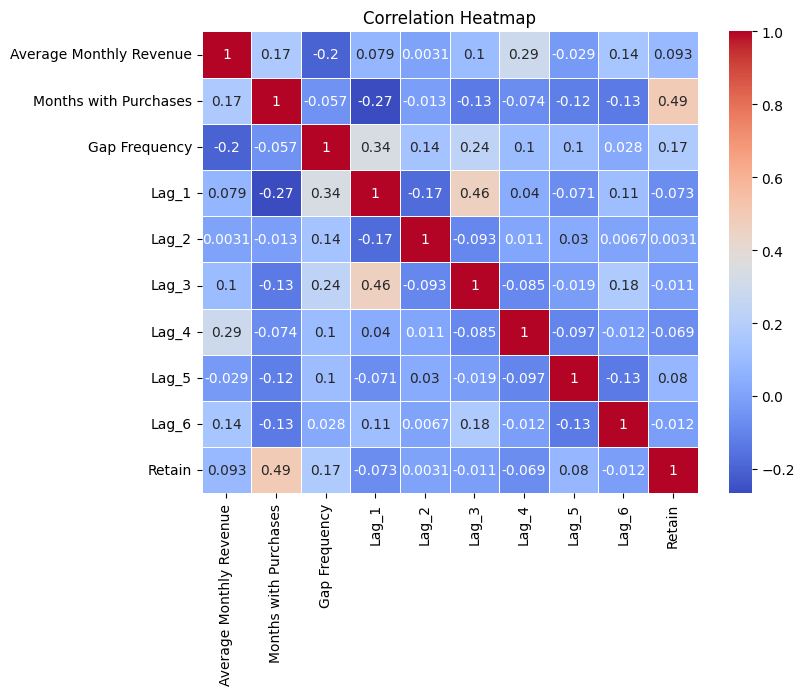

In [15]:
correlation_matrix = eda.corr(numeric_only = True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

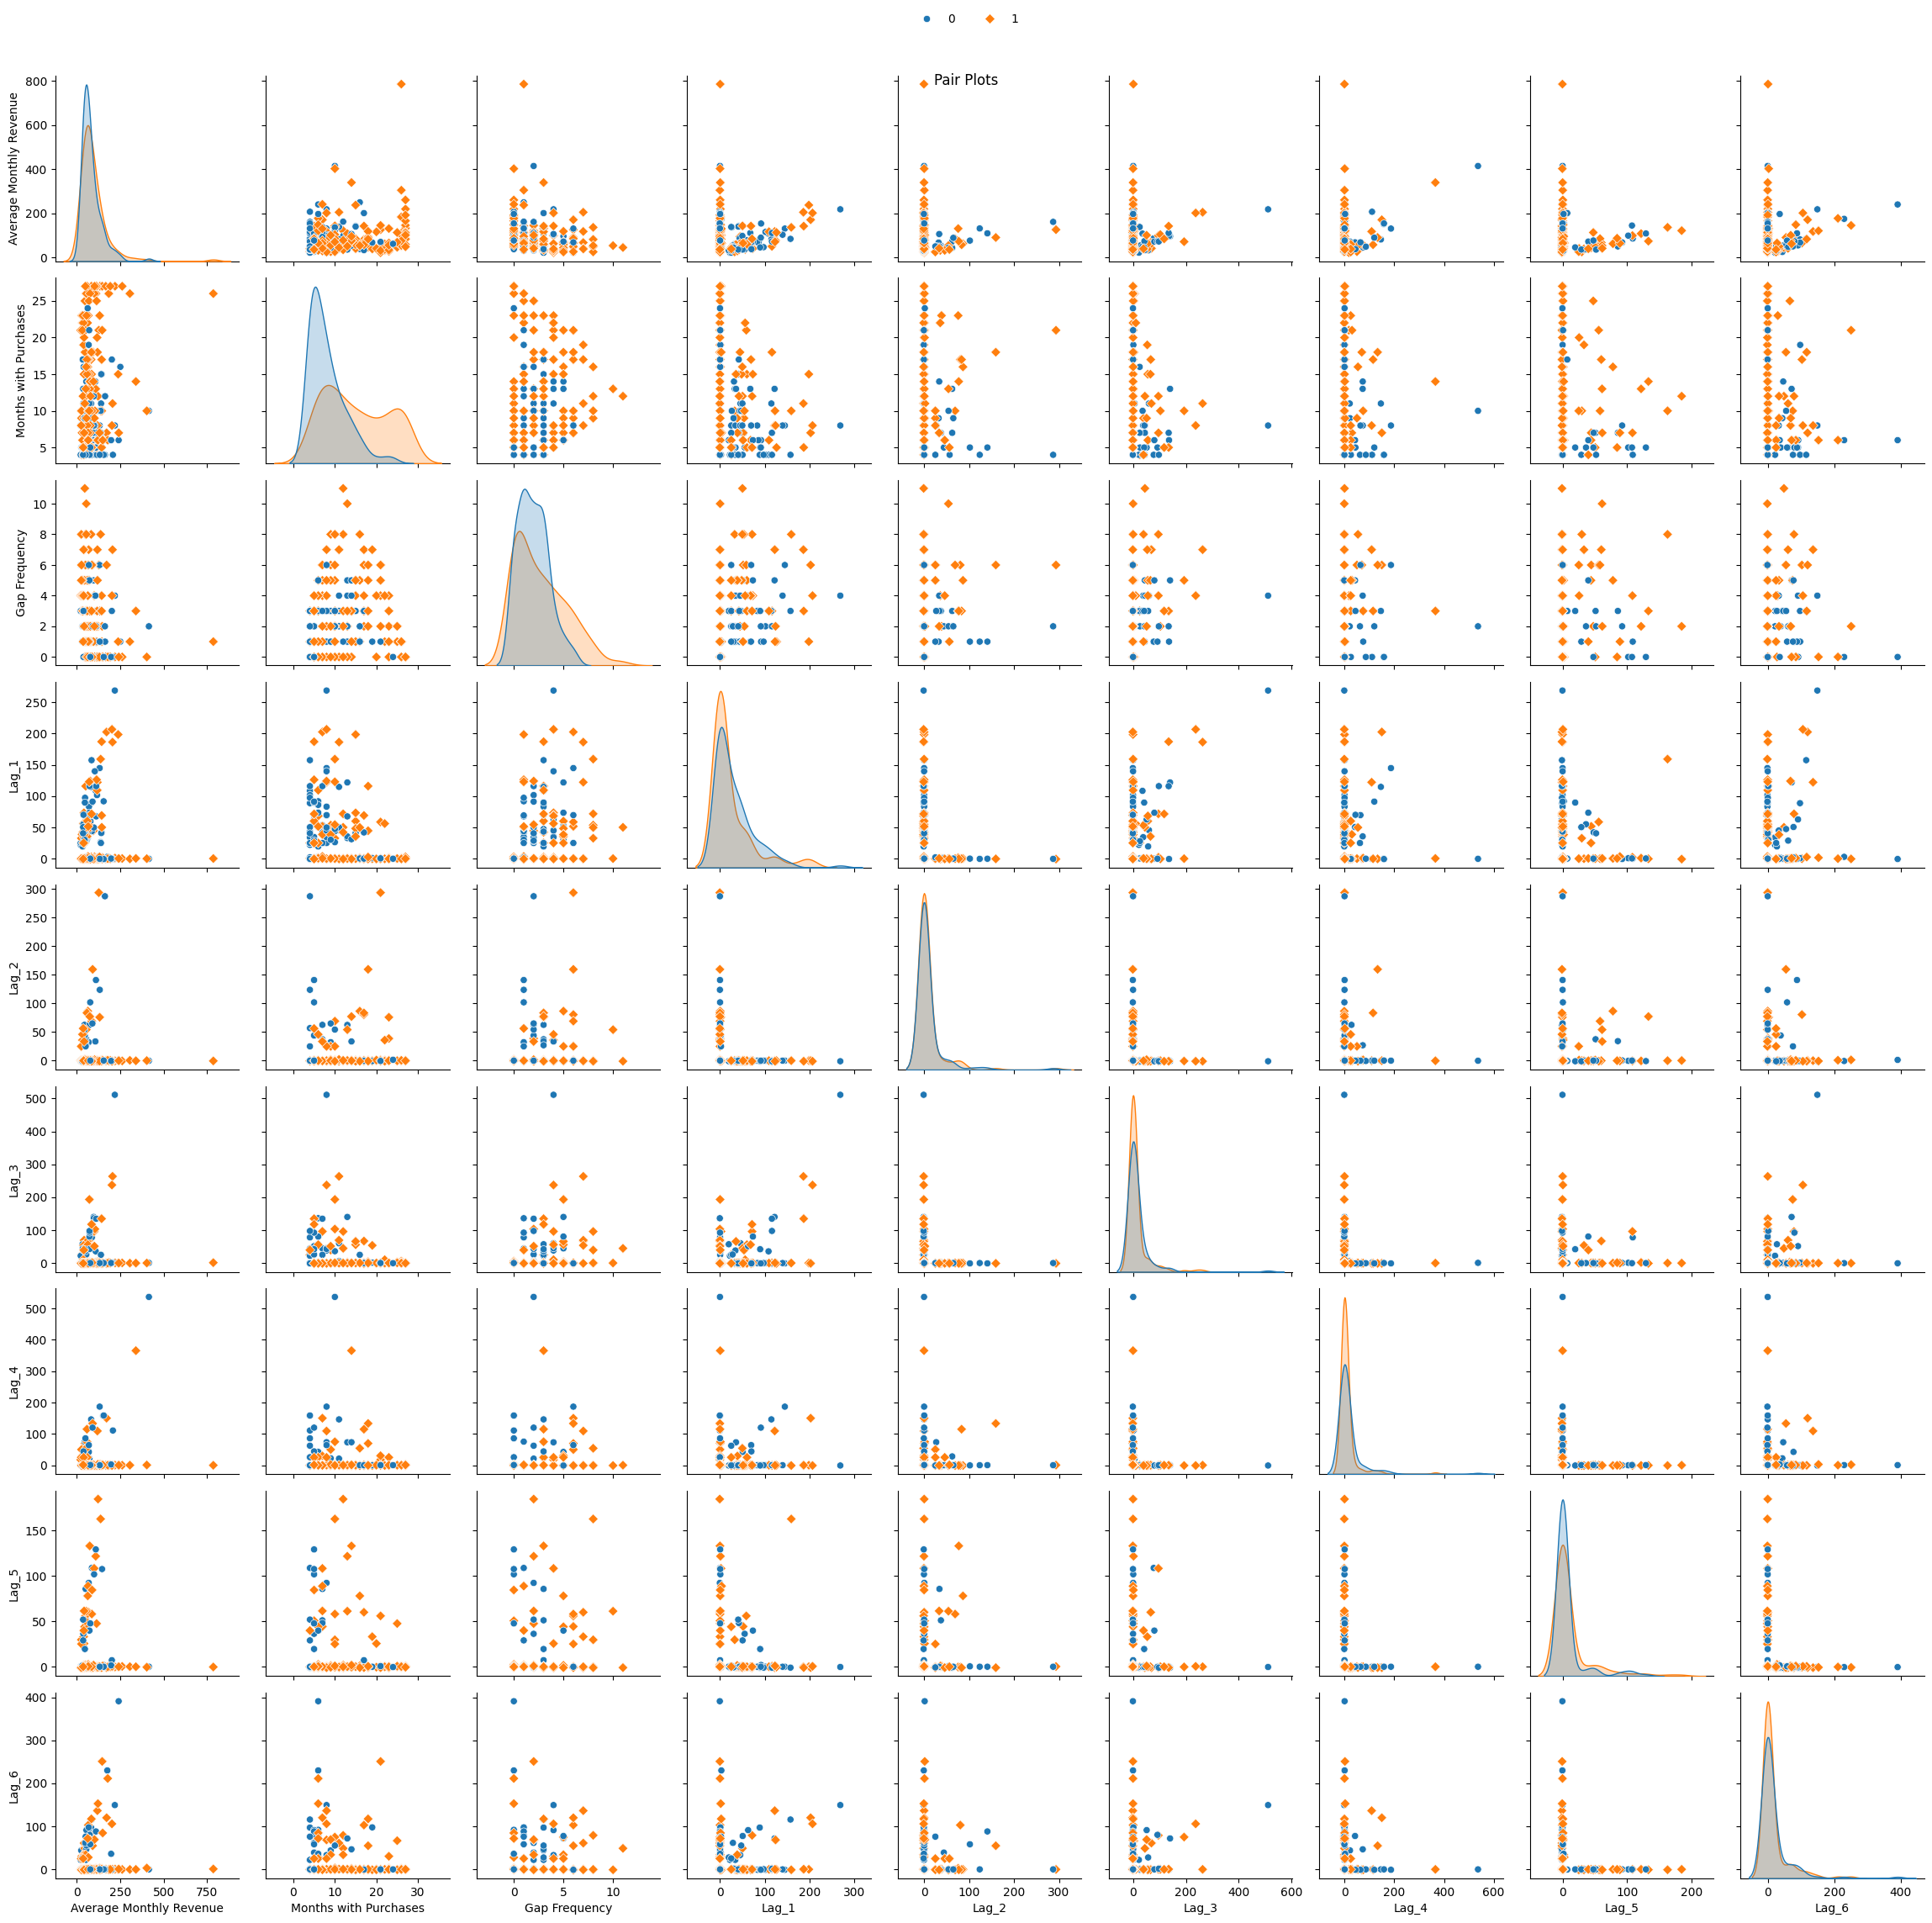

In [16]:
ax = sns.pairplot(eda, hue='Retain', markers=["o", "D"])
plt.suptitle("Pair Plots")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.tight_layout()
plt.show()

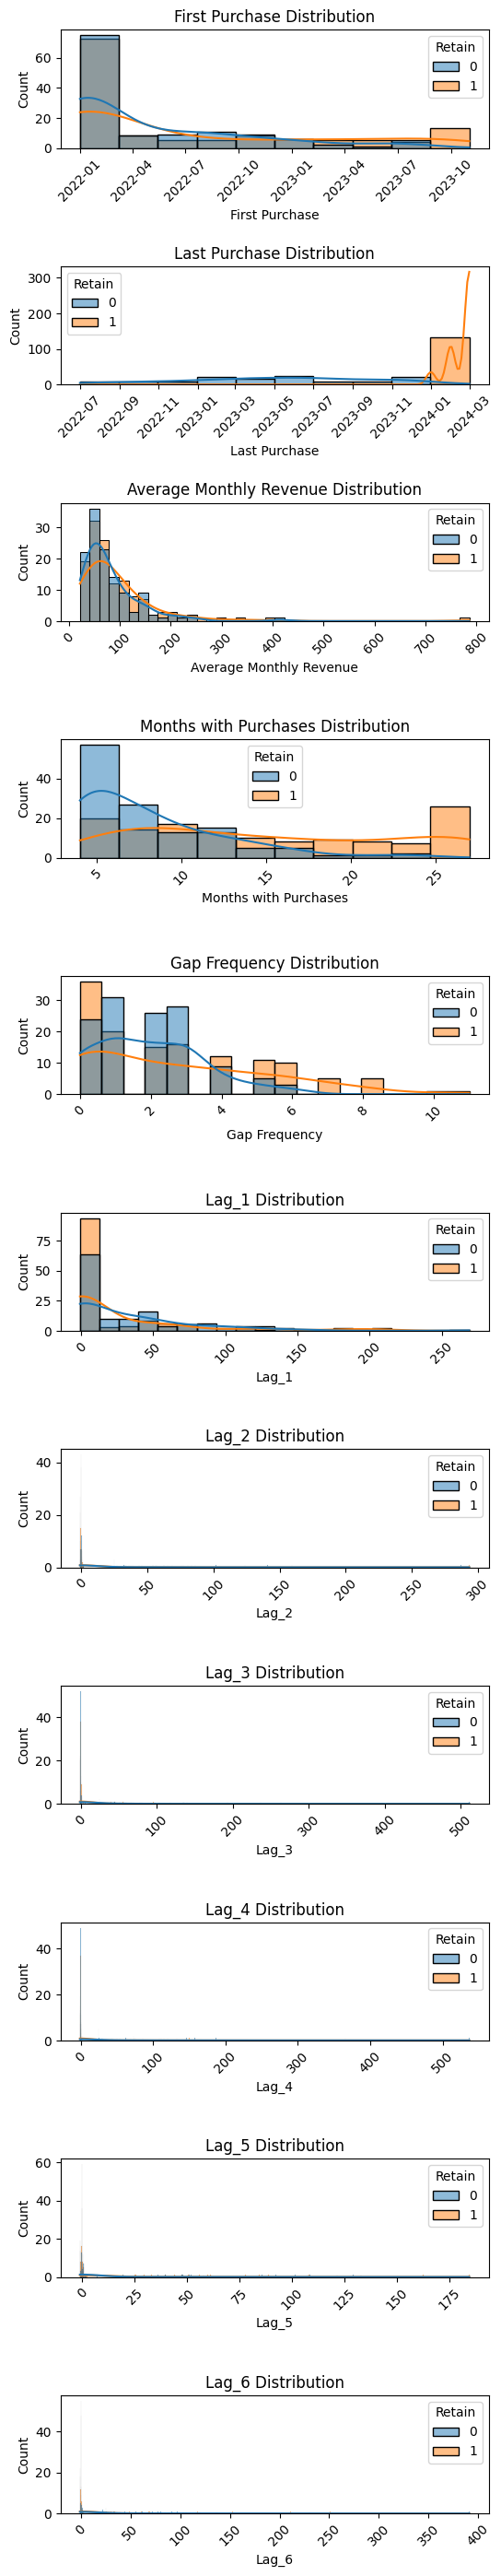

In [17]:
plt.figure(figsize=(6, 35))
for i, feature in enumerate(eda.columns[1:-1]):
    plt.subplot(len(eda.columns[1:-1]), 1, i + 1)
    sns.histplot(data=df, x=feature, hue='Retain', kde=True)
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)

plt.subplots_adjust(hspace=1)
plt.show()

# 'Drop Off' Machine Learning

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [19]:
#Define functions to automate model performance metrics presentation

def metrics(model):
    model_metrics = {}
    model_metrics['Accuracy'] = accuracy_score(y_test, eval(model+'_y_pred')).round(3)
    model_metrics['Error'] = (1 - model_metrics['Accuracy']).round(3)
    model_metrics['Cross Val'] = cross_val_score(eval(model+'_model'), X_test, y_test, cv=kfold).mean().round(3)
    model_metrics['Precision'] = precision_score(y_test, eval(model+'_y_pred')).round(3)
    model_metrics['Recall'] = recall_score(y_test, eval(model+'_y_pred')).round(3)
    model_metrics['F1'] = f1_score(y_test, eval(model+'_y_pred')).round(3)
    model_metrics['AUC Score'] = roc_auc_score(y_test, eval(model+'_y_prob')).round(3)
    model_metrics['Confusion Table'] = confusion_matrix(y_test, eval(model+'_y_pred')).round(3)
    return model_metrics

def print_metrics(model_name, model_metrics):
    print(f'{model_name} Model:\n',
      'Accuracy:', model_metrics['Accuracy'], '\n',
      'Error:', model_metrics['Error'], '\n',
      'CV Score:', model_metrics['Cross Val'], '\n',
      'Precision:', model_metrics['Precision'], '\n',
      'Recall:', model_metrics['Recall'], '\n',
      'F1 Score:', model_metrics['F1'], '\n',
      'AUC Score:', model_metrics['AUC Score'], '\n',
      model_metrics['Confusion Table'])

## Logistic Regression

In [20]:
import statsmodels.api as sm

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
logit_model = sm.Logit(y_train, X_train)
results = logit_model.fit()

#Classification predictions
logit_y_prob = results.predict(X_test)
logit_y_pred = (results.predict(X_test) > 0.5).astype(int)

#Note: statsmodel.api doesn't have built in cross validation score, and sklearn doesn't have results.summary function()
from sklearn.linear_model import LogisticRegression
logit_model_sklearn = LogisticRegression()
logit_model = LogisticRegression(max_iter=10000)
lm = logit_model.fit(X_train, y_train)
logit_cross_val = cross_val_score(logit_model, X_test, y_test, cv=kfold).mean()

#Performance metrics
logit_metrics = metrics('logit')
print_metrics('Logistic Regression', logit_metrics)

Optimization terminated successfully.
         Current function value: 0.536605
         Iterations 6
Logistic Regression Model:
 Accuracy: 0.769 
 Error: 0.231 
 CV Score: 0.664 
 Precision: 0.879 
 Recall: 0.674 
 F1 Score: 0.763 
 AUC Score: 0.844 
 [[31  4]
 [14 29]]


In [21]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:                 Retain   No. Observations:                  180
Model:                          Logit   Df Residuals:                      170
Method:                           MLE   Df Model:                            9
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:                  0.2258
Time:                        01:29:05   Log-Likelihood:                -96.589
converged:                       True   LL-Null:                       -124.76
Covariance Type:            nonrobust   LLR p-value:                 6.779e-09
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.9785      0.559     -5.332      0.000      -4.073      -1.884
Average Monthly Revenue     0.0049      0.004      1.319      0.187      -0.002       0.012


## KNN (K-Nearest Nieghbors)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Note: necessary scaling for KNN
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Model deployment
knn_model = KNeighborsClassifier(n_neighbors=50)
knn_model.fit(X_train, y_train)

#Classification prediction
knn_y_prob = knn_model.predict_proba(X_test)[:, 1]
knn_y_pred = (knn_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
knn_metrics = metrics('knn')
print_metrics('KNN', knn_metrics)

KNN Model:
 Accuracy: 0.705 
 Error: 0.295 
 CV Score: 0.397 
 Precision: 0.955 
 Recall: 0.488 
 F1 Score: 0.646 
 AUC Score: 0.812 
 [[34  1]
 [22 21]]


## Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

#Variables preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

#Classification predictions
nb_y_prob = nb_model.predict_proba(X_test)[:, 1]
nb_y_pred = (nb_model.predict(X_test) > 0.5).astype(int)

#Printing performance metrics
nb_metrics = metrics('nb')
print_metrics('Naive Bayes', nb_metrics)

Naive Bayes Model:
 Accuracy: 0.744 
 Error: 0.256 
 CV Score: 0.713 
 Precision: 0.829 
 Recall: 0.674 
 F1 Score: 0.744 
 AUC Score: 0.775 
 [[29  6]
 [14 29]]


## LDA (Linear Discriminant Analysis)

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
lda_model = LDA(store_covariance=True)
lda_model.fit(X_train, y_train)

#Classification predictions
y_test = y_test.astype(int)
lda_y_prob = lda_model.predict_proba(X_test)[:, 1]
lda_y_pred = (lda_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
lda_metrics = metrics('lda')
print_metrics('LDA', lda_metrics)

LDA Model:
 Accuracy: 0.782 
 Error: 0.218 
 CV Score: 0.69 
 Precision: 0.906 
 Recall: 0.674 
 F1 Score: 0.773 
 AUC Score: 0.845 
 [[32  3]
 [14 29]]


In [25]:
lda_model.priors_

array([0.50555556, 0.49444444])

In [26]:
lda_model.scalings_

array([[ 4.01061042e-03],
       [ 1.48175326e-01],
       [ 2.36564221e-01],
       [-2.61032194e-03],
       [-1.89840914e-03],
       [-1.17160072e-04],
       [-2.32671114e-03],
       [ 9.64656808e-03],
       [ 2.49741857e-03]])

## QDA (Quadratic Discriminant Analysis)

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
qda_model = QDA(store_covariance=True)
qda_model.fit(X_train, y_train)

#Classification predction
y_test = y_test.astype(int)
qda_y_prob = qda_model.predict_proba(X_test)[:, 1]
qda_y_pred = (qda_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
qda_metrics = metrics('qda')
print_metrics('QDA', qda_metrics)

QDA Model:
 Accuracy: 0.718 
 Error: 0.282 
 CV Score: 0.676 
 Precision: 0.8 
 Recall: 0.651 
 F1 Score: 0.718 
 AUC Score: 0.809 
 [[28  7]
 [15 28]]


## Decision Tree

In [28]:
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
import sklearn.model_selection as skm

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

feature_names = list(X.columns)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
dt = DTC(criterion='entropy', random_state=0)
dt.fit(X_train, y_train)

#Optimized tree pruning
ccp_path = dt.cost_complexity_pruning_path(X_train, y_train)

grid = skm.GridSearchCV(dt, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='accuracy')
grid.fit(X_train, y_train)
dt_model = grid.best_estimator_

#Classification prediction
dt_y_prob = dt_model.predict_proba(X_test)[:, 1]
dt_y_pred = (dt_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
dt_metrics = metrics('dt')
print_metrics('Decision Tree', dt_metrics)

Decision Tree Model:
 Accuracy: 0.641 
 Error: 0.359 
 CV Score: 0.667 
 Precision: 0.941 
 Recall: 0.372 
 F1 Score: 0.533 
 AUC Score: 0.672 
 [[34  1]
 [27 16]]


In [29]:
print('Unpruned Tree Nodes:')
dt.tree_.n_leaves

Unpruned Tree Nodes:


42

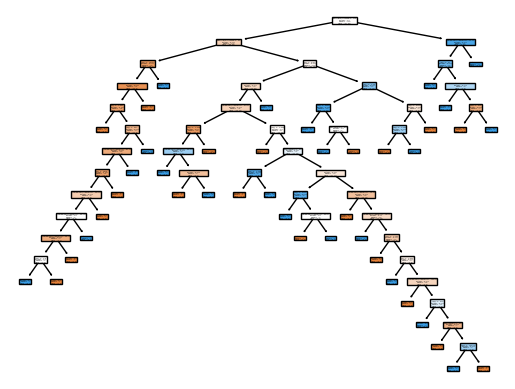

In [30]:
from matplotlib.pyplot import subplots

ax = subplots()[1]
plot_tree(dt, feature_names=feature_names, ax=ax, filled=True);

In [31]:
print('Pruned Tree Nodes:')
dt_model.tree_.n_leaves

Pruned Tree Nodes:


2

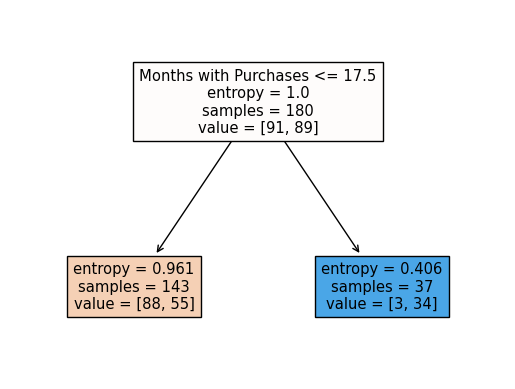

In [32]:
ax = subplots()[1]
plot_tree(dt_model, feature_names=feature_names, ax=ax, filled=True);

In [33]:
print(export_text(dt_model, feature_names=feature_names, show_weights=True))

|--- Months with Purchases <= 17.50
|   |--- weights: [88.00, 55.00] class: 0
|--- Months with Purchases >  17.50
|   |--- weights: [3.00, 34.00] class: 1



## SVM (Support Vector Machine)

In [34]:
from sklearn.svm import SVC

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
svm_model = SVC(kernel="linear", C=.01, probability=True)
svm_model.fit(X_train, y_train)

#Classification prediction
svm_y_prob = svm_model.predict_proba(X_test)[:, 1]
svm_y_pred = (svm_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
svm_metrics = metrics('svm')
print_metrics('SVM', svm_metrics)

SVM Model:
 Accuracy: 0.769 
 Error: 0.231 
 CV Score: 0.664 
 Precision: 0.879 
 Recall: 0.674 
 F1 Score: 0.763 
 AUC Score: 0.839 
 [[31  4]
 [14 29]]


## Bagging (Bootsrap Aggregation)

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500, max_samples=0.8, random_state=0, oob_score=True)
bag_model.fit(X_train, y_train)

#Classification predcition
bag_y_prob = bag_model.predict_proba(X_test)[:, 1]
bag_y_pred = (bag_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
bag_metrics = metrics('bag')
print_metrics('Bagging', bag_metrics)

print('\nOOB (Out-of-Bag) Score:', round(bag_model.oob_score_, 3))

Bagging Model:
 Accuracy: 0.692 
 Error: 0.308 
 CV Score: 0.639 
 Precision: 0.732 
 Recall: 0.698 
 F1 Score: 0.714 
 AUC Score: 0.8 
 [[24 11]
 [13 30]]

OOB (Out-of-Bag) Score: 0.65


## Boosting

In [36]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

#Variable preparation
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])
y = df['Retain']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#Model deployment
boost_model = GBR(n_estimators=1000, learning_rate=0.001, max_depth=3, random_state=0)
boost_model.fit(X_train, y_train)

#Classification prediction
boost_y_prob = boost_model.predict(X_test)
boost_y_pred = (boost_model.predict(X_test) > 0.5).astype(int)

#Performance metrics
boost_metrics = metrics('boost')
print_metrics('Boosting', boost_metrics)

Boosting Model:
 Accuracy: 0.795 
 Error: 0.205 
 CV Score: 0.029 
 Precision: 0.886 
 Recall: 0.721 
 F1 Score: 0.795 
 AUC Score: 0.846 
 [[31  4]
 [12 31]]


# Model Comparison

In [37]:
#Results data frame more metric comparison
models = {'Logistic Regression': 'logit',
          'KNN': 'knn',
          'Naive Bayes': 'nb',
          'LDA': 'lda',
          'QDA': 'qda',
          'Decision Tree': 'dt',
          'SVM': 'svm',
          'Bagging': 'bag',
          'Boosting': 'boost'}

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Error', 'CV Score', 'Precision', 'Recall', 'F1', 'AUC Score'])

for model_name, model_abbr in models.items():
    model_metrics = eval(model_abbr + '_metrics')
    results.loc[len(results)] = [
        model_name,
        model_metrics['Accuracy'],
        model_metrics['Error'],
        model_metrics['Cross Val'],
        model_metrics['Precision'],
        model_metrics['Recall'],
        model_metrics['F1'],
        model_metrics['AUC Score']
    ]
results

,Model,Accuracy,Error,CV Score,Precision,Recall,F1,AUC Score
0,Logistic Regression,0.769,0.231,0.664,0.879,0.674,0.763,0.844
1,KNN,0.705,0.295,0.397,0.955,0.488,0.646,0.812
2,Naive Bayes,0.744,0.256,0.713,0.829,0.674,0.744,0.775
3,LDA,0.782,0.218,0.690,0.906,0.674,0.773,0.845
4,QDA,0.718,0.282,0.676,0.800,0.651,0.718,0.809
5,Decision Tree,0.641,0.359,0.667,0.941,0.372,0.533,0.672
6,SVM,0.769,0.231,0.664,0.879,0.674,0.763,0.839
7,Bagging,0.692,0.308,0.639,0.732,0.698,0.714,0.800
8,Boosting,0.795,0.205,0.029,0.886,0.721,0.795,0.846


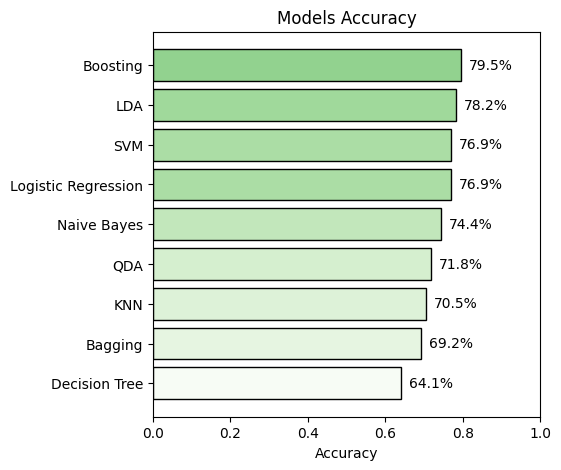

In [38]:
#Accuracy Bar Chart Visualization
model_accuracies = results.iloc[:, 0:2].sort_values(by='Accuracy')

cmap = plt.get_cmap('Greens')
norm = plt.Normalize(0.65, 1)

plt.figure(figsize=(5, 5))
bars = plt.barh(model_accuracies['Model'], model_accuracies['Accuracy'], color=cmap(norm(model_accuracies['Accuracy'])), edgecolor='k')
plt.title('Models Accuracy')
plt.xlabel('Accuracy')

# Add accuracy percentage values to bars
for bar, acc in zip(bars, model_accuracies['Accuracy']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f'{round(acc * 100, 2)}%', ha='left', va='center')

plt.xlim(0, 1)
plt.show()

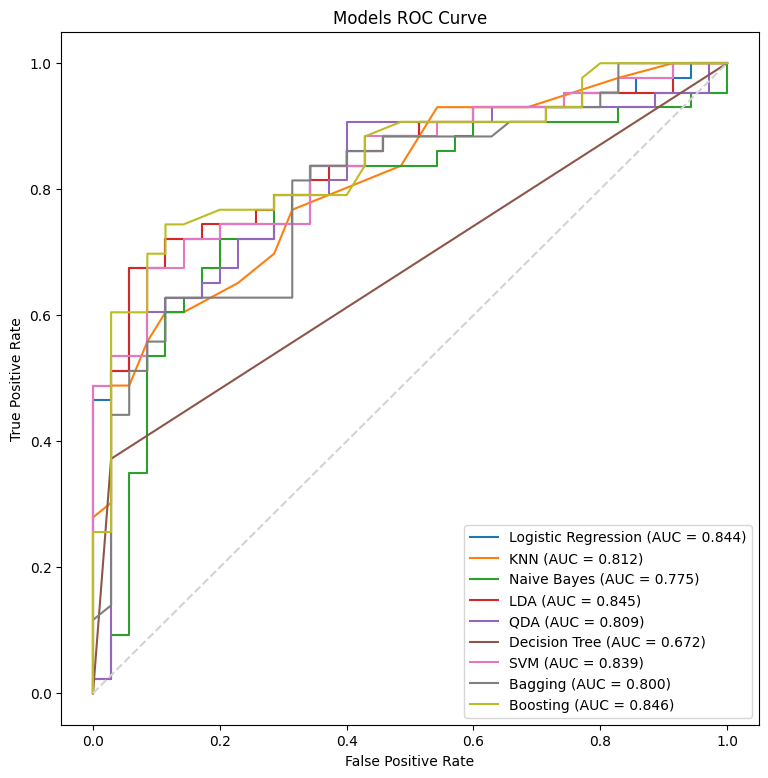

In [39]:
#ROC Curve Visualization

from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(9, 9))

for model_name, model_abbr in models.items():
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, eval(model_abbr + '_y_prob'))

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, eval(model_abbr + '_y_prob'))

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')

plt.title('Models ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# 'Drop Off' High Risk Customers Contact

In [40]:
#Implement customer retention model on full customer data
X = df.drop(columns = ['Full Name', 'First Purchase',	'Last Purchase', 'Retain'])

lda_prob = lda_model.predict_proba(X)[:, 1]
lda_pred = (lda_model.predict(X) > 0.5).astype(int)

df['Prediction'] = lda_pred
df['Probability'] = lda_prob

In [41]:
#Select customers who made a puchase in last 3 months but model predicted they wouldn't = High Risk Customers
contact = df[(df['Retain'] == 1) & (df['Prediction'] == 0)]
contact = contact.sort_values(by='Probability')

#Presenting high risk customers for portfolio presentation
contact_for_project = contact.drop(columns='Full Name')
contact_for_project.insert(0, 'Customer', contact.index)
contact_for_project[['Customer', 'Retain', 'Prediction', 'Probability']]

#note: these customers are then merged with cleaned customer contact information and create a new high risk customer contact list

,Customer,Retain,Prediction,Probability
257,257,1,0,0.124596
220,220,1,0,0.127660
219,219,1,0,0.149615
255,255,1,0,0.151064
247,247,1,0,0.160193
227,227,1,0,0.165236
36,36,1,0,0.165499
239,239,1,0,0.169828
234,234,1,0,0.178316
222,222,1,0,0.179332


In [43]:
#contact_info = pd.read_excel('/content/customers_clean.xlsx', header=0)

In [44]:
#merged_df = pd.merge(contact['Full Name'], contact_info[['Full Name', 'Phone']], on='Full Name', how='left')
#merged_df

In [45]:
#merged_df.to_excel('High_Risk_Customers.xlsx', index=False)